# Linear algebra in machine learning 

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning. I am  asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. I

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

     |████████████████████████████████| 8.6 MB 810 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from scipy import math
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.utils import shuffle
import requests 
import io
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Loading data and conducting a basic check that it's free from obvious issues.

In [15]:
# Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/yoav-karsenty/Linear-Algebra-in-Machine-Learning-/main/insurance_us.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

df

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


Renaming the colums to make the code look more consistent with its style.

In [16]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [17]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1948,0,27.0,37100.0,1,0
3250,1,30.0,29300.0,2,0
727,1,26.0,34200.0,0,0
2971,0,34.0,44000.0,1,0
2339,1,30.0,52600.0,4,0
2670,0,26.0,41600.0,3,0
4006,1,27.0,50600.0,2,0
1432,1,21.0,41300.0,1,0
2323,0,22.0,45800.0,1,0
3678,0,21.0,44300.0,2,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [19]:
# we may want to fix the age type (from float to int) though this is not critical
df['age'] = df['age'].astype(int)


In [20]:
# check to see that the conversion was successful
df.info()
# check there are no missing values
df.isna().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


0

In [21]:
#check for duplucated rows
df.duplicated().sum()

153

It seems there are 153 duplicated rows, but since there are no ids in the df and only 5 columns, i cant say for sure those rows are actually duplicated and since its a small portion of the data i will keep them as they will not disturb the analysis and model buliding

In [22]:
# now lest have a look at the data's descriptive statistics. 
df.describe()


,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Everything looks ok, but its clear the data is not scaled. the income column contains significantly high values compared to the other columns, this will have to be addressed later. 

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

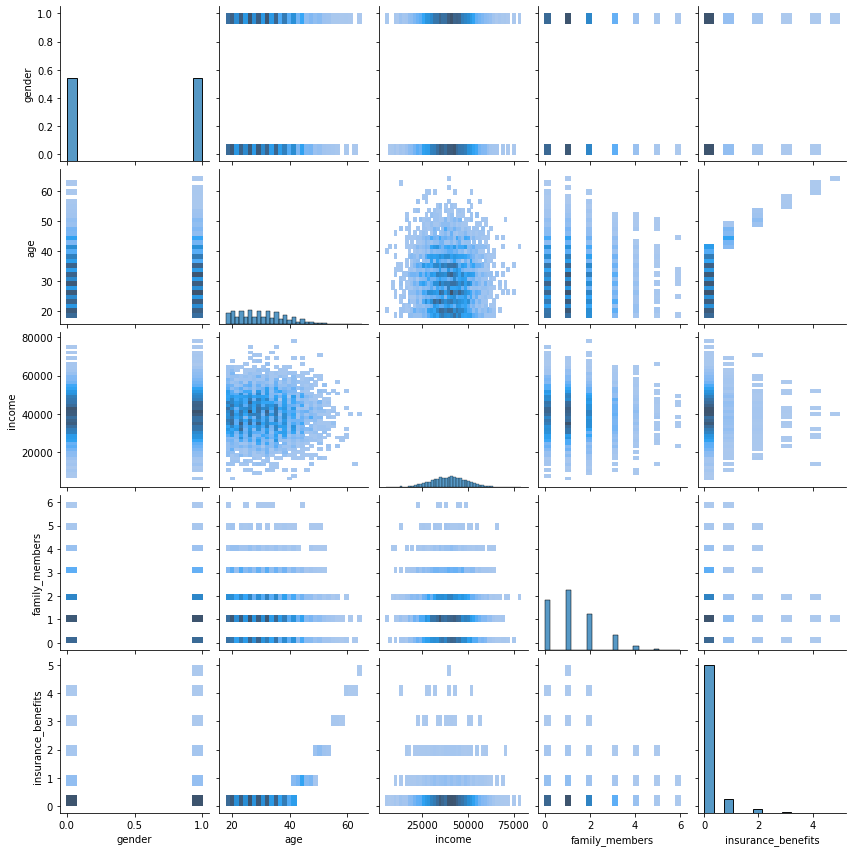

In [23]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

I will write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

Next, I Will test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler]
- Distance Metrics
  - Euclidean
  - Manhattan

I will answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [24]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [25]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
# fit the NearestNeighbours model to the dataset

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, algorithm='brute', metric=metric).fit(df[feature_names])
    # find the distances and the indexes of the k nearest observations to the vector n

    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [26]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [27]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1615,0.0,0.276923,0.521519,0.000000,0
2154,1.0,0.369231,0.610127,0.333333,0
980,0.0,0.538462,0.525316,0.500000,0
4574,1.0,0.461538,0.322785,0.000000,0
4111,0.0,0.353846,0.322785,0.166667,0


Now, let's get similar records for a given one for every combination

In [28]:
get_knn(df,5, 3,'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.0
3801,0,46,41000.0,2,1,4.0
3972,1,40,41000.0,1,0,4.0


In [29]:
get_knn(df,5, 3,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1995,0,45,41000.0,0,1,3.000000
3972,1,40,41000.0,1,0,3.162278


In [30]:
get_knn(df_scaled,5, 3,'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1147,1.0,0.646154,0.516456,0.333333,0,0.017916


In [31]:
get_knn(df_scaled,5, 3,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
1147,1.0,0.646154,0.516456,0.333333,0,0.015592
4074,1.0,0.661538,0.501266,0.333333,1,0.017722


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? how does that appear?** 

The data being not scaled does affect the kNN algorithm. The income column contains very high values compared to the rest of the columns so it is dominating the algorithm search for nearest neighbours. The neighbours that the algorithm found in the unscaled df all have the exact same income, wich can point that other features are not considerd as much as the income feature. 


**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results are preaty similar because these are the nearest neighbours by distance from the same vector [5]. 

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

I will:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. 
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
#check for distribution of values in the insurance_benefits column
df.insurance_benefits.value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

In [21]:
# calculate the target

df['insurance_benefits_received'] = np.where(df['insurance_benefits'] == 0,0,1)
df_scaled['insurance_benefits_received'] = np.where(df_scaled['insurance_benefits'] == 0,0,1)

df.sample(10)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
4149,1,31,25600.0,0,0,0
4773,1,47,45300.0,0,1,1
2669,1,29,38800.0,1,0,0
4616,0,38,29700.0,1,0,0
2240,0,60,27900.0,0,4,1
3447,1,25,37300.0,0,0,0
1282,0,43,31300.0,1,1,1
736,0,20,39200.0,1,0,0
4571,0,24,50100.0,0,0,0
1014,0,38,43300.0,1,0,0


In [22]:
# check for the class imbalance with value_counts()
df.insurance_benefits_received.value_counts()


0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [23]:

features = df[['gender', 'age', 'income', 'family_members']]
target = df['insurance_benefits_received']

In [24]:
#splitting the df into features and target of train df and test df 
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.30)
#building the model 
k=10
model = KNeighborsClassifier(n_neighbors=k)
model.fit(features_train, target_train)
predictions = model.predict(features_test)


In [25]:
#creating a function that evaluate the model using f1 score
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    return f1_score
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [26]:
eval_classifier(target_test,predictions)

F1: 0.02


0.023255813953488372

In [27]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
#Testing the dummt model 
dummies = []
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,len(df)) 
        
    ev = eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()
    dummies.append(ev)

The probability: 0.00
F1: 0.00

The probability: 0.11
F1: 0.12

The probability: 0.50
F1: 0.20

The probability: 1.00
F1: 0.20



F1: 0.64
F1: 0.33
F1: 0.35
F1: 0.13
F1: 0.14
F1: 0.07
F1: 0.07
F1: 0.05
F1: 0.05
F1: 0.03
list 1 [0.6385542168674698, 0.33043478260869563, 0.3534136546184739, 0.1313131313131313, 0.13793103448275862, 0.07329842931937172, 0.07253886010362694, 0.05376344086021505, 0.053475935828877004, 0.032432432432432434]
F1: 0.92
F1: 0.93
F1: 0.92
F1: 0.91
F1: 0.93
F1: 0.92
F1: 0.93
F1: 0.89
F1: 0.91
F1: 0.88
list 2 [0.9245901639344262, 0.9273356401384083, 0.9205298013245033, 0.9146757679180887, 0.9266666666666666, 0.923611111111111, 0.9283276450511945, 0.8936170212765957, 0.9128919860627177, 0.8840579710144928]


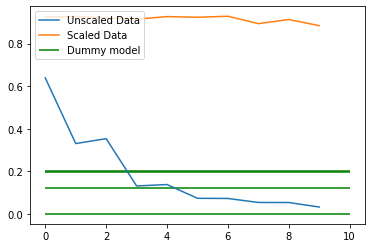

In [29]:
#Testing the model on scaled and unscaled data,

res = []
i = 0
for d in (df, df_scaled):
    i += 1
    current_res = []
    features = d[['gender', 'age', 'income', 'family_members']]
    target = d['insurance_benefits_received']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.30)
    for k in range (1,11):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(features_train, target_train)
        predictions = model.predict(features_test)
        ev = eval_classifier(target_test, predictions)
        current_res.append(ev)
        #append answer to list and visualize
    res.append(current_res)
    print(f'list {i}', current_res)

#visualizing the results
plt.plot(res[0],label="Unscaled Data")
plt.plot(res[1],label="Scaled Data")
     
plt.hlines(dummies, 0, 10,label="Dummy model",color='green')    

plt.legend(loc="upper left")

    
    

We can see that scaled model is performing much better then the dummy model and the unscaled model.
    

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

I will: 

Build my own implementation of LR. 

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [30]:
#Creating a LinearRegression model 
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights =  np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [31]:
# a function the will evaluate the model using rmse and r2 score metrics
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [32]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [33]:
sX = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
sy = df_scaled['insurance_benefits'].to_numpy()

sX_train, sX_test, sy_train, sy_test = train_test_split(sX, sy, test_size=0.3, random_state=12345)

slr = MyLinearRegression()

slr.fit(sX_train, sy_train)
print(slr.weights)

sy_test_pred = slr.predict(sX_test)
eval_regressor(sy_test, sy_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


It seems that the RMSE and R2 score does not change using the scaled_df or tthe normal df

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features by an invertible matrix $P$. 

$$
X' = X \times P
$$

I wil ltry to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

In [34]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:

X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generating a random matrix $P$.

In [36]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))


Checking the matrix $P$ is invertible

In [37]:
print(P @ ( np.linalg.inv(P)))


[[ 1.00000000e+00  1.85130588e-16 -2.97856902e-16 -3.91584367e-17]
 [ 6.23834470e-17  1.00000000e+00 -7.10568689e-17  8.24459807e-17]
 [ 1.03941594e-17  2.27454503e-17  1.00000000e+00 -5.77784356e-17]
 [-1.02697151e-16 -1.69379178e-16 -2.49945035e-17  1.00000000e+00]]


Can you guess the customers' ages or income after the transformation?

In [38]:
X_transformed = X @ P
X_transformed

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

seems like Obfuscating the data worked. We cant detect customers' ages or income after the transformation. 

In [39]:
#recovering p 
X_transformed @ np.linalg.inv(P)

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

In [40]:
#checking if after recovering the data X is the same as X_transformed @ np.linalg.inv(P)
np.allclose(X_transformed @ np.linalg.inv(P), X)

True

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [41]:
#print(X[:5, :])
def X2df(X):
    return pd.DataFrame(columns=personal_info_column_list, data=X)
print(X2df(X[:5, :]))
print(X2df((X @ P)[:5, :]))
print(X2df(((X @ P) @ np.linalg.inv(P))[:5, :]))


   gender   age   income  family_members
0     1.0  41.0  49600.0             1.0
1     0.0  46.0  38000.0             1.0
2     0.0  29.0  21000.0             0.0
3     0.0  21.0  41700.0             2.0
4     1.0  28.0  26100.0             0.0
        gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378
         gender   age   income  family_members
0  1.000000e+00  41.0  49600.0    1.000000e+00
1  1.679528e-12  46.0  38000.0    1.000000e+00
2 -6.230214e-13  29.0  21000.0   -2.030327e-13
3 -1.089078e-12  21.0  41700.0    2.000000e+00
4  1.000000e+00  28.0  26100.0   -1.524242e-12


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The values are not exactly the same as they are in the original data probably due to numpy floating point percision.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. My next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same.

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

The questions in hand are:
How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?



**Answer**

We know that :

$(AB)^T = B^TA^T$

and SINCE 

$ W_P = [(XP)^T XP]^{-1} (XP)^Ty$ 

THEN 



$W_P = [P^TX^TXP]^{-1}(XP)^Ty$



$W_P = P^{-1}[X^T X]^{-1} (P^T)^{-1}P^TX^Ty$



$W_P = P^{-1}[X^T X]^{-1}X^Ty$

-----


# Showing how  would  𝑤  and  𝑤𝑃  be linked if you simplify the formula for  𝑤𝑃 



$W = (X^T X)^{-1} X^T y$

$W_P = P^{-1}(X^T X)^{-1}X^Ty$

# What would be predicted values with  𝑤𝑃 ?

predictions of the model with weights 𝑤 and feature matrix  𝑋:

$𝑦̂ =𝑋𝑤$


predictions of the model with weights 𝑤p and feature matrix  𝑋 x P:

 $𝑦̂ =(𝑋P)P^{-1}𝑤$


What does that mean for the quality of linear regression if you measure it with RMSE?


This means that the quality of linear regression wont change even after Data Obfuscation.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [42]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(5, 5))

In [189]:
print(P @ ( np.linalg.inv(P)))


[[ 1.00000000e+00 -2.84035922e-16  2.10401104e-16 -2.86310615e-16
   2.81531702e-16]
 [ 7.73248958e-17  1.00000000e+00 -7.05363534e-17  1.50275815e-16
  -1.09253087e-16]
 [ 1.02377186e-16 -1.61127177e-16  1.00000000e+00  1.45620334e-16
  -4.61133016e-17]
 [-9.74847361e-17  7.90223196e-17  6.35997421e-17  1.00000000e+00
  -9.79527690e-17]
 [ 2.79574282e-18 -1.07835225e-16  3.21526012e-16 -4.02228983e-18
   1.00000000e+00]]


In [190]:
class MyLinearRegressionP:
    
    def __init__(self, P):
        
        self.weights = None
        self.P = P
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = (np.linalg.inv(((X2@P).T) @ (X2@P))) @ ((X2@P).T) @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2@P.dot(self.weights)
        
        return y_pred

In [191]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lrp = MyLinearRegressionP(P)

lrp.fit(X_train, y_train)
print(lrp.weights)

y_test_pred = lrp.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-1.32253665  0.31686536  0.65549686 -1.10485986  1.57898247]
RMSE: 0.34
R2: 0.66


# Conclusions

In this project, i have:
1. found customers who are similar to a given customer, using the k nearest neighbors Algorithm, in order to help the company's agents with marketing.
2.  Predicted whether a new customer is likely to receive an insurance benefit using the KNN-based classifier and proved it  can do better than a dummy model. 
3. Predicted the number of insurance benefits a new customer is likely to receive using a linear regression model i build. I have also shown that in most cases, the models i have build performs better with scaled data.
4. Protected clients' personal data without breaking the model. I have proven that using Data Obfuscation to protect clients' personal data does not affect the models quality with RMSE AND R2 (it was the same, 0.34 RMSE and 0.66 R2) metrics and also with mathematical explenation. 